In [1]:
# For saving models and histories
import pandas as pd
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:05<00:00, 123MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [3]:
# Corrected path for Windows environment
dataset_dir = r'/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1'

# List all files and directories in the dataset folder
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")

Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized
Directory: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns

In [5]:
import pathlib
import random
import shutil
path1 = r"/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized"
path2 = r"/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected"

# Define the number of images to select from each folder
num_images = 3750

# Define the combined data directory where selected images will be stored
combined_data_dir = r"/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/malaria_combineddata"
pathlib.Path(combined_data_dir).mkdir(parents=True, exist_ok=True)

# Define paths for the new 'Parasitized' and 'Uninfected' directories inside combined directory
parasitized_dir = pathlib.Path(combined_data_dir) / 'Parasitized'
uninfected_dir = pathlib.Path(combined_data_dir) / 'Uninfected'

# Create the directories if they don't exist
parasitized_dir.mkdir(parents=True, exist_ok=True)
uninfected_dir.mkdir(parents=True, exist_ok=True)

# Get all image files in each directory
parasitized_images = list(pathlib.Path(path1).glob('*'))
uninfected_images = list(pathlib.Path(path2).glob('*'))

# Randomly select 2500 images from each folder
selected_parasitized_images = random.sample(parasitized_images, num_images)
selected_uninfected_images = random.sample(uninfected_images, num_images)

# Combine the selected images
combined_images = selected_parasitized_images + selected_uninfected_images

# Shuffle the combined list
random.shuffle(combined_images)

# Move the shuffled images to the new directory
for img_file in combined_images:
    if img_file in selected_parasitized_images:
        shutil.copy(img_file, parasitized_dir / img_file.name)
    else:
        shutil.copy(img_file, uninfected_dir / img_file.name)

print(f"Images have been combined and shuffled. The combined dataset is saved to: {combined_data_dir}")

Images have been combined and shuffled. The combined dataset is saved to: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/malaria_combineddata


In [6]:
img_width = 150
img_height = 150
batch_size = 32

# ImageDataGenerator for training data (with augmentation)
train_image_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, # Define the validation split
    validation_split=0.2,
)

# ImageDataGenerator for validation data (without augmentation)
val_image_gen = ImageDataGenerator(
    rescale=1/255,  # Only normalize the images
    validation_split=0.2
)

# Create the flow from directory for training
train_data = train_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="training",  # Specify that this is the training data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=True  # Shuffle the training data
)

# Create the flow from directory for validation
val_data = val_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="validation",  # Specify that this is the validation data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=False  # No need to shuffle the validation data
)



Found 6000 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.


In [ ]:
print(train_data.class_indices)

{'Parasitized': 0, 'Uninfected': 1}


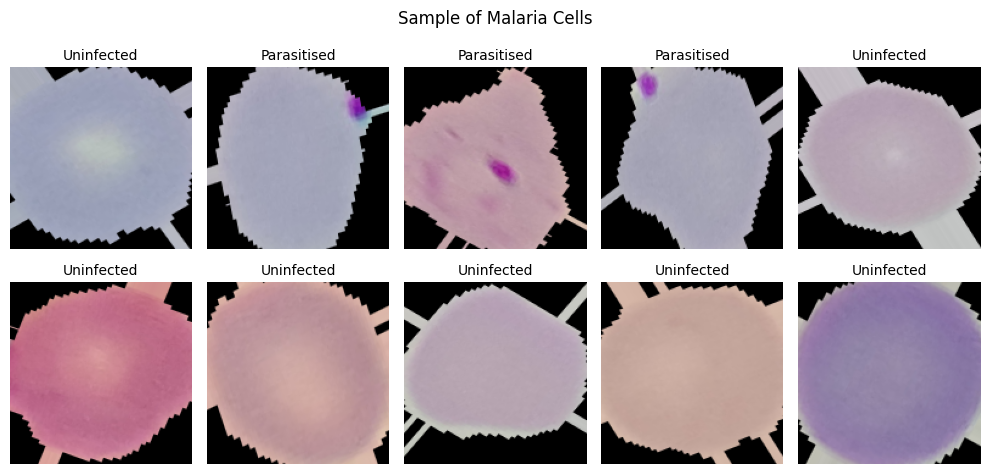

In [ ]:
X_train, y_train = next(train_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

# Part 1: CNNs

In [ ]:
input = Input(shape=(img_width, img_height, 3), dtype='float32', name='malaria_cells')

# First Convolutional Block
X = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(input)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Second Convolutional Block
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(X)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Third Convolutional Block
X = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(X)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Flatten()(X)

# Dense layers with Dropout
X = Dense(256, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(128, activation='relu')(X)
# X = Dropout(0.3)(X)

# Output layer
output = Dense(1, activation='sigmoid', name='cell_classes')(X)

# Create the model
model = Model(inputs=input, outputs=output)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      10,617,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cell_classes (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,744,257 (40.99 MB)

 Trainable params: 10,743,809 (40.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [ ]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

C:\Users\jiayi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 173s 907ms/step - accuracy: 0.5563 - loss: 1.6203 - val_accuracy: 0.5100 - val_loss: 0.7079
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 139s 736ms/step - accuracy: 0.6062 - loss: 0.6851 - val_accuracy: 0.5547 - val_loss: 0.6544
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 758ms/step - accuracy: 0.6410 - loss: 0.6560 - val_accuracy: 0.6073 - val_loss: 0.6474
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 141s 751ms/step - accuracy: 0.7252 - loss: 0.5642 - val_accuracy: 0.8580 - val_loss: 0.5862
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 763ms/step - accuracy: 0.8071 - loss: 0.4585 - val_accuracy: 0.8640 - val_loss: 0.3998


In [ ]:
model.save("malaria-cnn-v0.keras")

In [ ]:
model.evaluate(val_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8597 - loss: 0.2971


[0.3997945487499237, 0.8640000224113464]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step
              precision    recall  f1-score   support

 Parasitized       0.86      0.87      0.86       750
  Uninfected       0.86      0.86      0.86       750

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



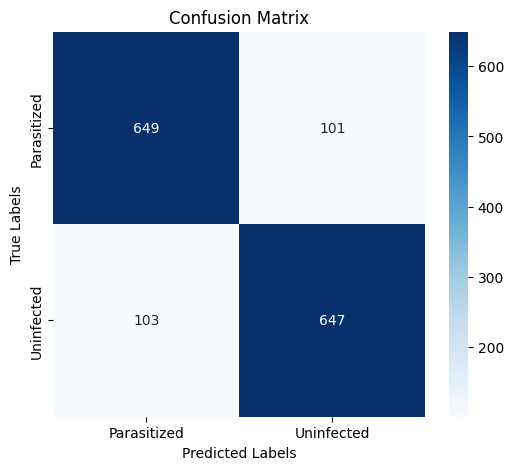

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

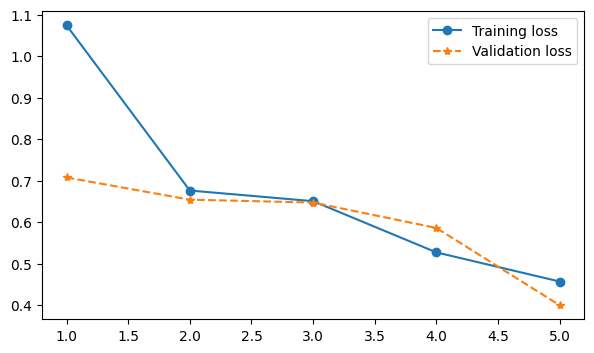

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

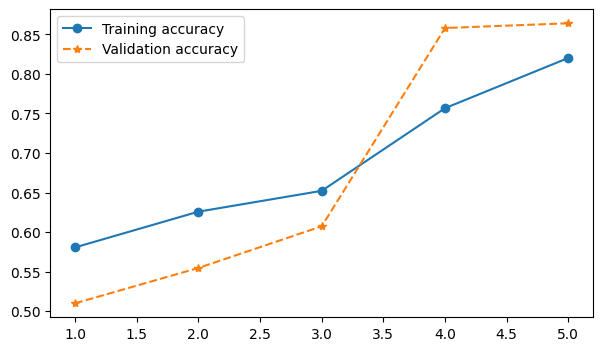

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

---

In [ ]:
# Define parameters
batch_size = 32
img_height = 224  # VGG16 expects 224x224 input images
img_width = 224


In [ ]:
# ImageDataGenerator for training data (with augmentation)
train_image_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, # Define the validation split
    validation_split=0.2,
)

# ImageDataGenerator for validation data (without augmentation)
val_image_gen = ImageDataGenerator(
    rescale=1/255,  # Only normalize the images
    validation_split=0.2
)

# Create the flow from directory for training
train_data = train_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="training",  # Specify that this is the training data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=True  # Shuffle the training data
)

# Create the flow from directory for validation
val_data = val_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="validation",  # Specify that this is the validation data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=False  # No need to shuffle the validation data
)


Found 6000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),  # Flatten the feature maps
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])


In [ ]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 921s 5s/step - accuracy: 0.6541 - loss: 0.9006 - val_accuracy: 0.7413 - val_loss: 0.4836
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 921s 5s/step - accuracy: 0.8102 - loss: 0.4274 - val_accuracy: 0.8447 - val_loss: 0.3474
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 897s 5s/step - accuracy: 0.8469 - loss: 0.3714 - val_accuracy: 0.8580 - val_loss: 0.3188
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 871s 5s/step - accuracy: 0.8537 - loss: 0.3349 - val_accuracy: 0.8907 - val_loss: 0.2724
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 833s 4s/step - accuracy: 0.8662 - loss: 0.3274 - val_accuracy: 0.8980 - val_loss: 0.2782


In [ ]:
model.save("malaria-cnn-v1.keras")

In [ ]:
model.evaluate(val_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9177 - loss: 0.2011


[0.2781997323036194, 0.8980000019073486]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
              precision    recall  f1-score   support

 Parasitized       0.87      0.93      0.90       750
  Uninfected       0.93      0.86      0.89       750

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



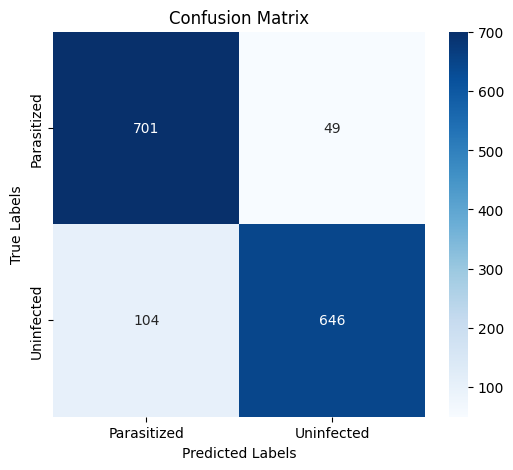

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

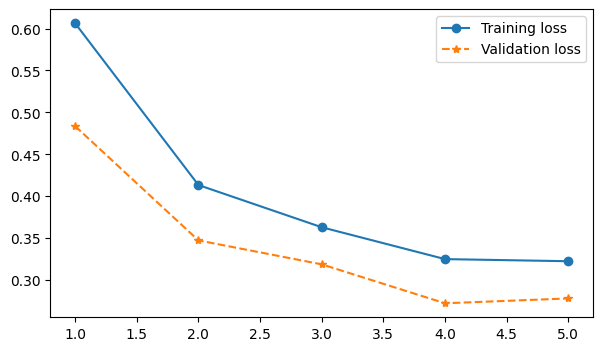

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

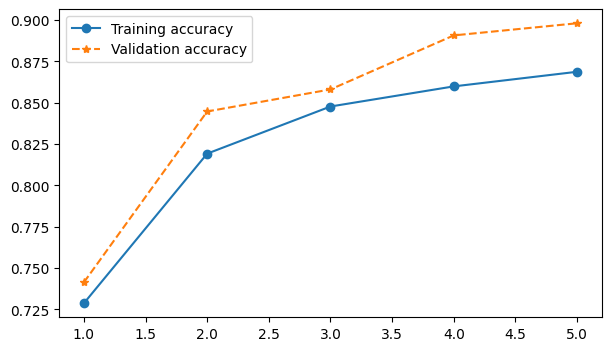

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

---

In [ ]:
input = Input(shape=(img_width, img_height, 3), dtype='float32', name='malaria_cells')

# First Convolutional Block
X = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(input)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Second Convolutional Block
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(X)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

# Third Convolutional Block
# X = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', dilation_rate=(1, 1), groups = 1)(X)
# X = BatchNormalization(axis = 3)(X)
# X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = GlobalAveragePooling2D()(X)

# Dense layers with Dropout
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(128, activation='relu')(X)
# X = Dropout(0.1)(X)

# Output layer
output = Dense(1, activation='sigmoid', name='cell_classes')(X)

# Create the model
model = Model(inputs=input, outputs=output)

# Print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cell_classes (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,441 (271.25 KB)

 Trainable params: 69,249 (270.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [ ]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.6293 - loss: 0.6503 - val_accuracy: 0.5000 - val_loss: 0.8182
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7298 - loss: 0.5542 - val_accuracy: 0.5013 - val_loss: 2.2248
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8530 - loss: 0.3768 - val_accuracy: 0.6227 - val_loss: 0.7299
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8808 - loss: 0.3165 - val_accuracy: 0.7733 - val_loss: 0.4318
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8852 - loss: 0.3173 - val_accuracy: 0.9013 - val_loss: 0.2648


In [ ]:
model.save("malaria-cnn-v2.keras")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step
              precision    recall  f1-score   support

 Parasitized       0.97      0.83      0.89       750
  Uninfected       0.85      0.98      0.91       750

    accuracy                           0.90      1500
   macro avg       0.91      0.90      0.90      1500
weighted avg       0.91      0.90      0.90      1500



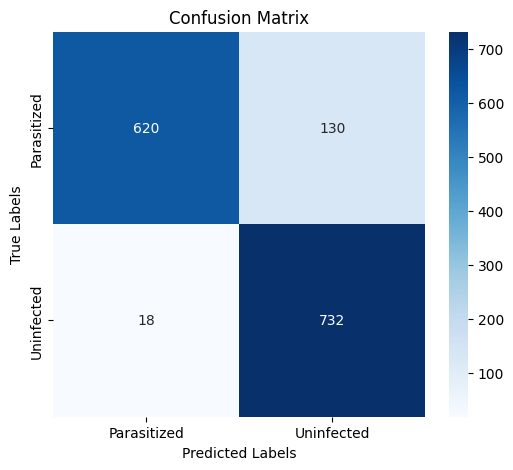

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

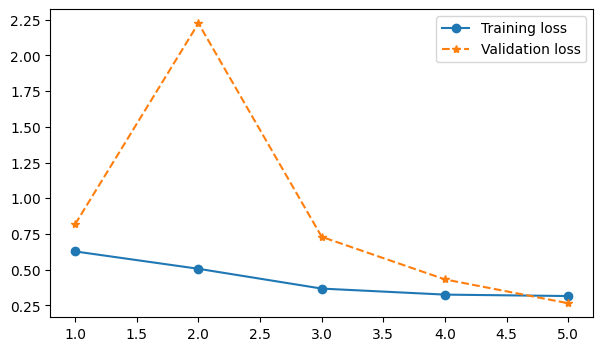

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

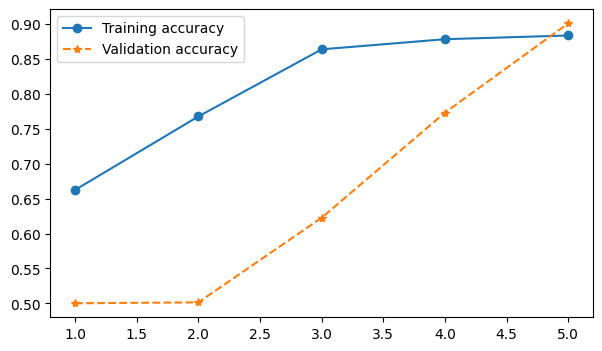

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

# Part 2: Resnet-50 & Inception V3

In [7]:
# Define parameters
batch_size = 32
img_height = 224  # VGG16 expects 224x224 input images
img_width = 224

In [8]:
# ImageDataGenerator for training data (with augmentation)
train_image_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, # Define the validation split
    validation_split=0.2,
)

# ImageDataGenerator for validation data (without augmentation)
val_image_gen = ImageDataGenerator(
    rescale=1/255,  # Only normalize the images
    validation_split=0.2
)

# Create the flow from directory for training
train_data = train_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="training",  # Specify that this is the training data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=True  # Shuffle the training data
)

# Create the flow from directory for validation
val_data = val_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="validation",  # Specify that this is the validation data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=False  # No need to shuffle the validation data
)


Found 6000 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.


In [24]:
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = resnet_v2.ResNet50V2(include_top=False, weights="imagenet")
base_model.trainable = True
# test
model = Sequential([
    base_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [25]:
# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, None, None, 2048)    │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, None, 2048)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 23,781,761 (90.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [14]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0115)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])


In [15]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 165s 605ms/step - accuracy: 0.5800 - loss: 0.6799 - val_accuracy: 0.5070 - val_loss: 0.7409
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 476ms/step - accuracy: 0.6251 - loss: 0.6516 - val_accuracy: 0.2715 - val_loss: 50.4174
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 141s 466ms/step - accuracy: 0.8892 - loss: 0.3729 - val_accuracy: 0.5003 - val_loss: 124.9152
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 141s 468ms/step - accuracy: 0.9205 - loss: 0.2964 - val_accuracy: 0.9446 - val_loss: 0.1925
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 470ms/step - accuracy: 0.9354 - loss: 0.2350 - val_accuracy: 0.9213 - val_loss: 0.4511


In [20]:
import json
# rmb to save to drive
model.save('/content/drive/MyDrive/AML/malaria_resnet50.keras')

with open('/content/drive/MyDrive/AML/resnet50_training_history.json', 'w') as f:
    json.dump(history.history, f)

In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step
              precision    recall  f1-score   support

 Parasitized       0.98      0.86      0.92       750
  Uninfected       0.88      0.98      0.93       749

    accuracy                           0.92      1499
   macro avg       0.93      0.92      0.92      1499
weighted avg       0.93      0.92      0.92      1499



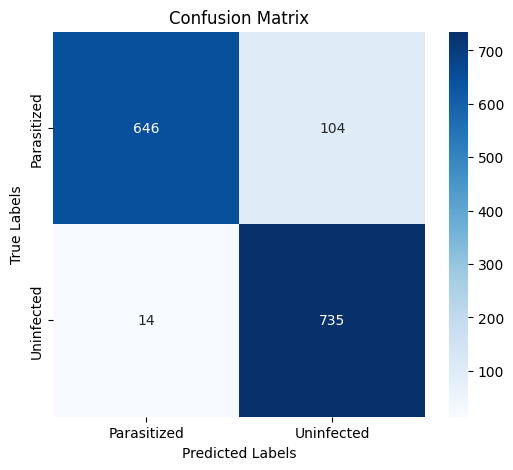

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

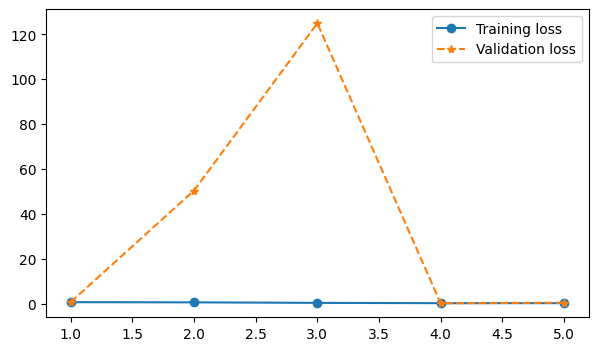

In [18]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

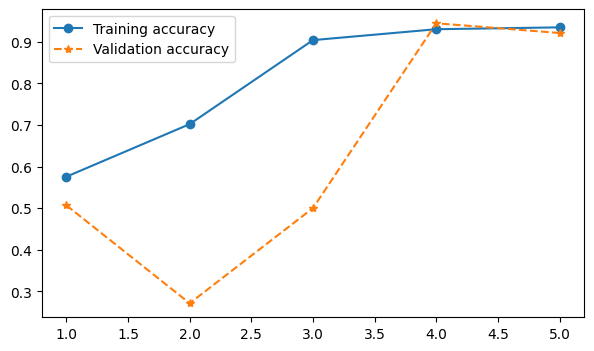

In [19]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

---

In [ ]:
# Define parameters
batch_size = 32
img_height = 299  # VGG16 expects 224x224 input images
img_width = 299

In [ ]:
# ImageDataGenerator for training data (with augmentation)
train_image_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, # Define the validation split
    validation_split=0.2,
)

# ImageDataGenerator for validation data (without augmentation)
val_image_gen = ImageDataGenerator(
    rescale=1/255,  # Only normalize the images
    validation_split=0.2
)

# Create the flow from directory for training
train_data = train_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="training",  # Specify that this is the training data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=True  # Shuffle the training data
)

# Create the flow from directory for validation
val_data = val_image_gen.flow_from_directory(
    combined_data_dir,  # Directory with images
    subset="validation",  # Specify that this is the validation data
    class_mode="binary",  # Binary classification
    target_size=(img_width, img_height),  # Resize images
    batch_size=batch_size,  # Set the batch size
    shuffle=False  # No need to shuffle the validation data
)


Found 6000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_inception.trainable = False

model = Sequential()
model.add(base_inception)

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.optimizers import RMSprop


optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()
epochs = 5

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

# model.compile(optimizer=RMSprop(learning_rate=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [ ]:
# Ensure the model trains on GPU if available
with tf.device('/GPU:0'):  # Use GPU if available
    history = model.fit(
        train_data,         # The training data
        epochs=epochs,         # Number of epochs to train
        validation_data=val_data  # Validation data to evaluate during training
    )

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 183s 841ms/step - accuracy: 0.7023 - loss: 0.5634 - val_accuracy: 0.8840 - val_loss: 0.2869
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 134s 693ms/step - accuracy: 0.8585 - loss: 0.3339 - val_accuracy: 0.8820 - val_loss: 0.2710
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 140s 680ms/step - accuracy: 0.8689 - loss: 0.3047 - val_accuracy: 0.9000 - val_loss: 0.2498
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 684ms/step - accuracy: 0.8757 - loss: 0.2944 - val_accuracy: 0.8973 - val_loss: 0.2470
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 134s 687ms/step - accuracy: 0.8731 - loss: 0.2979 - val_accuracy: 0.9080 - val_loss: 0.2366


In [ ]:
# rmb to save to drive
model.save('/content/drive/MyDrive/AML/malaria_inception_v3.keras')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the validation data
predictions = model.predict(val_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Get the true labels
true_labels = val_data.classes  # Actual labels from the validation data

# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=val_data.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step
              precision    recall  f1-score   support

 Parasitized       0.92      0.89      0.91       750
  Uninfected       0.89      0.93      0.91       750

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500



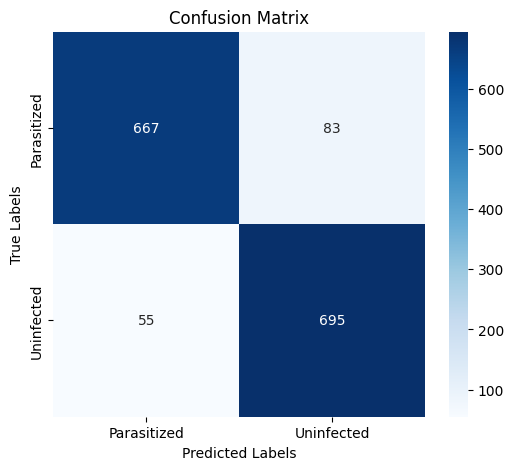

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

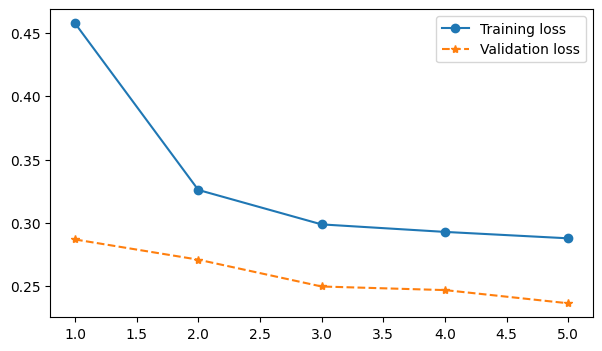

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

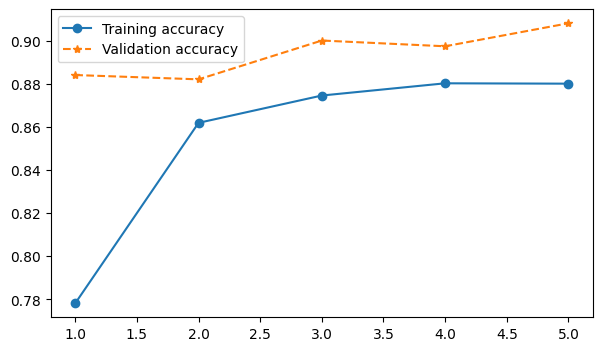

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()